### This notebook is designed for learning transition matrix of markov chains
### It also defines in-context loss for markov chain learning tasks

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import torch

import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
from data.serialize import SerializerSettings

# Check if directory exists, if not create it
if not os.path.exists('plot_output'):
    os.makedirs('plot_output')

%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import dataclass

@dataclass
class Scaler:
    """
    Represents a data scaler with transformation and inverse transformation functions.

    Attributes:
        transform (callable): Function to apply transformation.
        inv_transform (callable): Function to apply inverse transformation.
    """
    transform: callable = lambda x: x
    inv_transform: callable = lambda x: x    

def get_scaler(history, alpha=0.95, beta=0.3, basic=False):
    """
    Generate a Scaler object based on given history data.

    Args:
        history (array-like): Data to derive scaling from.
        alpha (float, optional): Quantile for scaling. Defaults to .95.
        # Truncate inputs
        tokens = [tokeniz]
        beta (float, optional): Shift parameter. Defaults to .3.
        basic (bool, optional): If True, no shift is applied, and scaling by values below 0.01 is avoided. Defaults to False.

    Returns:
        Scaler: Configured scaler object.
    """
    history = history[~np.isnan(history)]
    if basic:
        q = np.maximum(np.quantile(np.abs(history), alpha),.01)
        def transform(x):
            return x / q
        def inv_transform(x):
            return x * q
    else:
        min_ = np.min(history) - beta*(np.max(history)-np.min(history))
        q = np.quantile(history-min_, alpha)
        def transform(x):
            return (x - min_) / q
        def inv_transform(x):
            return x * q + min_
    return Scaler(transform=transform, inv_transform=inv_transform)

def llama_nll_fn_pure_string(tokenizer, good_tokens, logit_mat, input_str, target_str, temp):
    """ Returns the NLL/dimension (log base e) of the target array (continuous) according to the LM 
        conditioned on the input array. Applies relevant log determinant for transforms and
        converts from discrete NLL of the LLM to continuous by assuming uniform within the bins.
    inputs:
        input_arr: (n,) context array
        target_arr: (n,) ground truth array
    Returns: NLL/D
    """
    full_series = input_str + target_str
    
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
    batch = {k: v.cuda() for k, v in batch.items()}
    input_ids = batch['input_ids'][0][1:]
    
    bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
    logit_mat[:,:,bad_tokens] = -np.inf
    
    if not isinstance(temp, list):
        temp = [temp]
        
    input_len = len(input_str)
    nll_list = []
    for t in temp:
        logprobs = torch.nn.functional.log_softmax(logit_mat/t, dim=-1)[0][:-1]
        # logprob of the full trajectory
        logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
        # logprob of test (target) trajectory
        logprobs = logprobs[input_len:]
        BPD = -logprobs.sum()/len(target_str)
        nll_list += [BPD]
        
    return nll_list


## Define models ##

In [5]:
time_sep=', '
bit_sep=''
plus_sign=''
minus_sign='-'

### Generate Markov Chain Data

Nt = 200 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

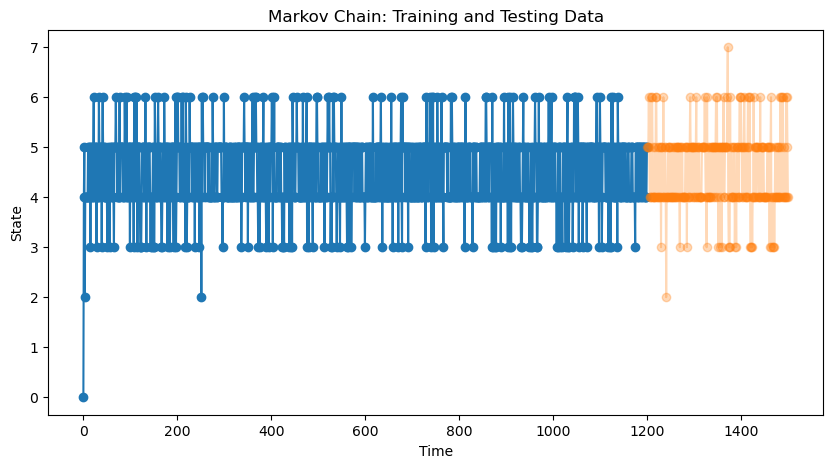

Transition matrix:
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00
0.00 0.00 0.00 0.07 0.43 0.43 0.07 0.00 0.00 0.00


In [8]:
### Force all conditioned distribution to be the same
### This results in discretized Orstein-Uhlenbeck Process
OU = True
sigma = 1.0
# sigma = 3.0
sigma = 0.5

# number of states
N_state = 10
# N_state = 9
# N_state = 8
# N_state = 6
# N_state = 5
# N_state = 4


# number of steps
Nt = 1500
# Nt = 3000
# Nt = 1000



states = np.arange(N_state)
states_string = "".join(str(x) for x in states)
# good_tokens_str = list("0123456789" + settings.time_sep)
good_tokens_str = list(states_string + time_sep)



# Initialize the chain with a starting state, for example, state 0
chain = [0]

# Define the transition matrix P
# Rows sum to 1
def generate_transition_matrix(N_state):
    """
    Generate a random transition matrix of shape (N_state, N_state).
    Each row sums to 1.
    """
    P = np.random.rand(N_state, N_state)
    P /= P.sum(axis=1)[:, np.newaxis]
    return P

def generate_gaussian_matrix(N_state, sigma):
    """
    Generate a transition matrix of shape (N_state, N_state) for an uncorrelated Brownian motion.
    Each row will be the same, representing discretized bins of a Gaussian distribution.
    The sum of each row is normalized to 1.

    :param N_state: Number of states (and thus size of the transition matrix)
    :param sigma: Standard deviation of the Gaussian distribution (controls the width of the Gaussian)
    """
    # Define the bins for the Gaussian distribution
    bins = np.linspace(-3, 3, N_state)
    
    # Calculate the Gaussian distribution values for these bins
    gaussian_distribution = np.exp(-0.5 * (bins / sigma) ** 2)
    gaussian_distribution /= gaussian_distribution.sum()  # Normalize to sum to 1

    # Repeat this distribution for each row to create the transition matrix
    P = np.tile(gaussian_distribution, (N_state, 1))

    return P

# Generate the chain
np.random.seed(1)

if OU:
    P = generate_gaussian_matrix(N_state, sigma)
else:
    P = generate_transition_matrix(N_state)

for t in range(1, Nt):
    current_state = chain[-1]
    next_state = np.random.choice(states, p=P[current_state])
    chain.append(next_state)
    
# Create a time span
tspan = np.arange(Nt)

# Store the generated time-series in a pandas DataFrame
df = pd.DataFrame({'Time': tspan, 'X': chain})


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train, alpha=1, marker = 'o', label='Training Data')
plt.plot([np.nan]*len(train)+list(test), alpha=0.3, marker = 'o', label='Testing Data')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Markov Chain: Training and Testing Data')
plt.show()

print("Transition matrix:")
for row in P:
    # plt.figure(figsize=(4, 1), dpi=100)
    # plt.bar(states, row)
    # plt.show()
    print(" ".join(f"{x:.2f}" for x in row))


### Convert time series to strings

In [13]:
full_series = "".join(str(x) for x in chain)
full_array = np.array(chain)

### Compute Logits

In [16]:
torch.cuda.empty_cache()

from models.llama import get_model_and_tokenizer, get_tokenizer
model, tokenizer = get_model_and_tokenizer('13b')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [17]:

batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
batch = {k: v.cuda() for k, v in batch.items()}

with torch.no_grad():
    out = model(**batch)
    

with open(f"plot_output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
            pickle.dump(out['logits'], f)

OutOfMemoryError: CUDA out of memory. Tried to allocate 346.00 MiB (GPU 0; 15.73 GiB total capacity; 5.38 GiB already allocated; 304.88 MiB free; 5.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
logit_mat = out['logits']

In [14]:
### Use computed logits from above
# logit_mat = out['logits']

### or load pickled logit_mat file from plot_output
# # 13-b, 6 states
# with open('plot_output/2023-11-02_18-31-45.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # 13-b, 4 states
# with open('plot_output/2023-11-02_22-08-20.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# 13-b, 10 states
# with open('plot_output/2023-11-02_22-11-25.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 7-b, 4 states
# with open('plot_output/2023-11-02_22-37-41.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# 7-b, 6 states
# with open('plot_output/2023-11-02_22-40-55.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 7-b, 10 states
# with open('plot_output/2023-11-02_22-45-04.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)


# # 70-b, 10 states
# with open('plot_output/2023-11-02_22-56-16.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 70-b, 6 states
# with open('plot_output/2023-11-02_23-00-09.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)


# # 70-b, 4 states
# with open('plot_output/2023-11-02_23-10-05.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # 70-b, 8 states
# with open('plot_output/2023-11-02_23-14-05.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 70-b, 9 states
# with open('plot_output/2023-11-02_23-17-24.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# 7-b, 10 states, OU, sigma = 1
# with open('plot_output/2023-11-07_17-34-45.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# 7-b, 5 states, OU, sigma = 1
# with open('plot_output/2023-11-07_17-47-59.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# 7-b, 8 states, OU, sigma = 1
# with open('plot_output/2023-11-07_17-50-36.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # 13-b, 10 states, OU, sigma = 1
# with open('plot_output/2023-11-07_19-11-40.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)    
    
# # 13-b, 10 states, OU, sigma = 3
# with open('plot_output/2023-11-07_19-16-53.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)       

# 13-b, 10 states, OU, sigma = 0.5
# with open('plot_output/2023-11-07_19-19-43.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)   

In [15]:
print(good_tokens_str)

good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]

logit_mat = logit_mat[:,:,good_tokens].cpu()
T = 1
digit_index = -100

probs = torch.nn.functional.softmax(logit_mat / T, dim=-1)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Interactive Plot

In [16]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import torch
T = 1
# Assuming logit_mat, T, good_tokens_str, full_array, and full_series are defined
# ...


string_labels = [label for label in good_tokens_str]
full_array_len = len(full_array)
width = 0.4

def digiprob_plotter(digit_idx=-2):
    
    fig, axs = plt.subplots(2, 1, figsize = (12,6))
    
    # Add distance between the two main plots
    plt.subplots_adjust(hspace=0.4)  # Adjust the horizontal space between subplots
    
    axs[0].plot(full_array, marker='o', ls = 'none')
    preceding_state = full_array[full_array_len + digit_idx]
    axs[0].plot(full_array_len + digit_idx, preceding_state, color='r', marker='o')
    
    probs_array = probs[:, digit_idx].cpu().numpy()[0]
    axs[1].set_title(full_series[-30 + digit_idx + 1:digit_idx + 1] + "?")
    
    # Create the bars, shifting the x position for one set
    axs[1].bar(states + width/2, probs_array, width, alpha=0.5, color='b', label="LLM prediction")
    axs[1].bar(states - width/2, P[preceding_state], width, alpha=0.5, color='r', label="True transition")

    # Set other plot properties
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability")
    axs[1].set_xticks(states)
    axs[1].set_xticklabels(string_labels)

    # Show legend
    axs[1].legend()

    # Show the plot
    plt.show()

# interact(digiprob_plotter, digit_idx=(-1500, -5, 1))
interact(digiprob_plotter, digit_idx=(-Nt, -5, int(Nt/20)))

interactive(children=(IntSlider(value=-5, description='digit_idx', max=-5, min=-1500, step=75), Output()), _do…

<function __main__.digiprob_plotter(digit_idx=-2)>

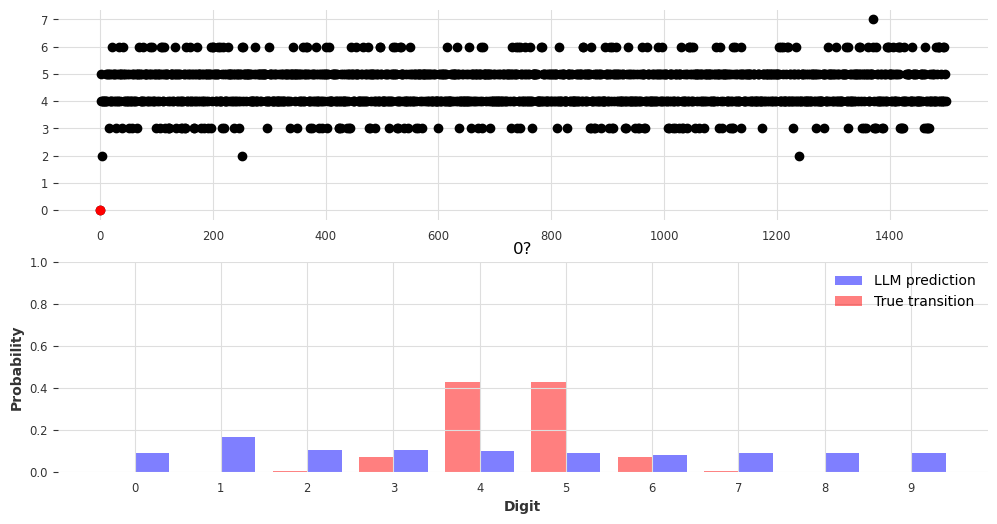

In [ ]:
# Rendering GIF

import matplotlib.animation as animation

probs = torch.nn.functional.softmax(logit_mat / T, dim=-1)
string_labels = [label for label in good_tokens_str]
full_array_len = len(full_array)

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

def update(digit_idx):
    axs[0].cla()
    axs[1].cla()
    
    axs[0].plot(full_array, marker='o', ls = 'none')
    preceding_state = full_array[full_array_len + digit_idx]
    axs[0].plot(full_array_len + digit_idx, preceding_state, color='r', marker='o')
    
    probs_array = probs[:, digit_idx].cpu().numpy()[0]
    axs[1].set_title(full_series[-30 + digit_idx + 1:digit_idx + 1] + "?")
    
    # Create the bars, shifting the x position for one set
    axs[1].bar(states + width/2, probs_array, width, alpha=0.5, color='b', label="LLM prediction")
    axs[1].bar(states - width/2, P[preceding_state], width, alpha=0.5, color='r', label="True transition")

    # Set other plot properties
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability")
    axs[1].set_xticks(states)
    axs[1].set_xticklabels(string_labels)

    # Show legend
    axs[1].legend()


# ani = animation.FuncAnimation(fig, update, frames=np.arange(-1500, -2, 1), interval=200)
ani = animation.FuncAnimation(fig, update, frames=np.arange(-Nt, -5, int(Nt/20)), interval=200)

# Save the animation as an MP4 file
ani.save('digiprob_plotter_7B_6s.gif', writer='pillow')

### Loss function over time

In [17]:
start_idx = 0

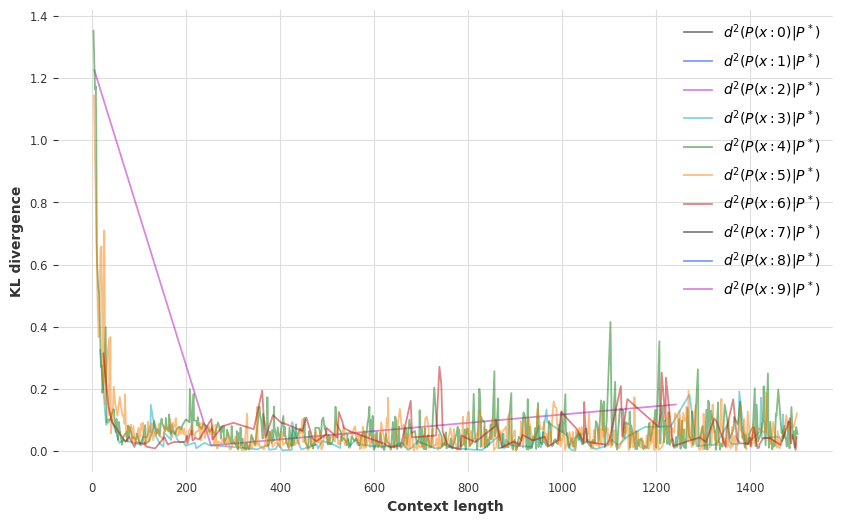

In [20]:
dist_type = "KL"

# dist_type = "BH"
### Weighted KL divergence
plt.figure(figsize=(10,6))
loss_array = np.zeros(full_array[start_idx:].squeeze().shape)
# for state in states[[0,1]]:
for state in states:
    ### add 2 to slice out BOS
    pos = np.where(full_array[start_idx:]==state)[0]+2
    learned_p_out = probs.squeeze()[start_idx:][pos]
    true_p_out = torch.tensor(P[state])
    if dist_type == 'KL':
    ### KL divergence at each row
        KL = torch.sum(true_p_out * (true_p_out.log() - learned_p_out.log()), dim = 1)
        dist = KL
    else:
        ### Bhattacharyya distance at each row
        sqrt_PQ = torch.sum(torch.sqrt(learned_p_out * true_p_out), dim = 1)
        BH_dist = -torch.log(sqrt_PQ)
        dist = BH_dist
    
    loss_array[pos-2] = dist.numpy()
    plt.plot(pos, dist, label = f"$d^2(P(x:{state})| P^*)$", alpha = 0.5)

    # plt.loglog()
    plt.xlabel("Context length")
    plt.ylabel("KL divergence")
    plt.legend()


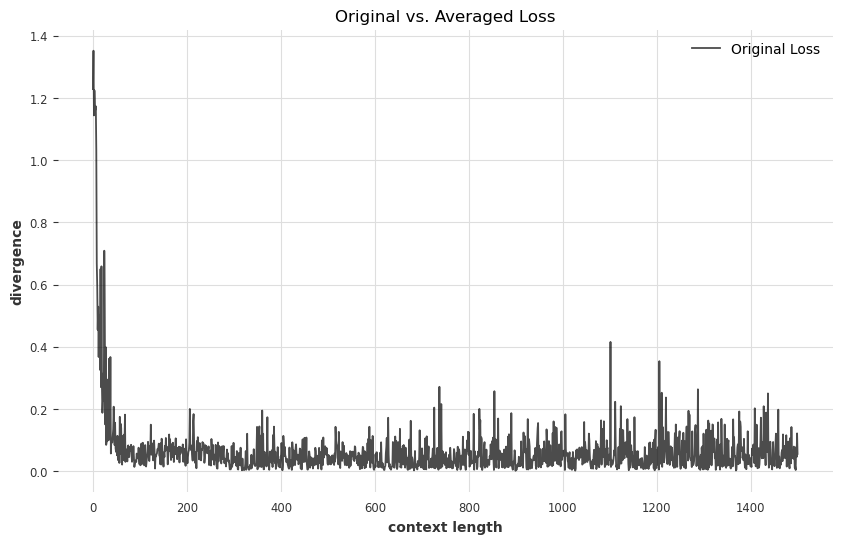

In [21]:
# Define a top-hat kernel for averaging
window_size = 10
top_hat_kernel = np.ones(window_size) / window_size

# Convolve the loss_array with the top-hat kernel
averaged_loss = np.convolve(loss_array, top_hat_kernel, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_array, label="Original Loss", alpha=0.7)
# plt.plot(np.arange(window_size//2, len(loss_array) - window_size//2 + 1), averaged_loss, label="Averaged Loss", linewidth=2)
plt.ylabel('divergence')
plt.xlabel("context length")
# plt.loglog()
plt.legend()
plt.title("Original vs. Averaged Loss")
plt.show()

### Tuning Temperature

In [22]:
# N_state = 4
# N_state = 8
# N_state = 9

states = np.arange(N_state)
states_string = "".join(str(x) for x in states)
good_tokens_str = list(states_string + settings.time_sep)
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]


In [23]:
### Use computed logits from above
# logit_mat = out['logits']

# # 13-b, 6 states
# with open('plot_output/2023-11-02_18-31-45.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)


# 13-b, 10 states
# with open('plot_output/2023-11-02_22-11-25.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)


# # 7-b, 10 states
# with open('plot_output/2023-11-02_22-45-04.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)


# # 70-b, 10 states
# with open('plot_output/2023-11-02_22-56-16.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# 70-b, 6 states
# with open('plot_output/2023-11-02_23-00-09.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 13-b, 6 states
# with open('plot_output/2023-11-02_18-31-45.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# 7-b, 6 states
# with open('plot_output/2023-11-02_22-40-55.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # # 70-b, 4 states
# with open('plot_output/2023-11-02_23-10-05.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 13-b, 4 states
# with open('plot_output/2023-11-02_22-08-20.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# 7-b, 4 states
# with open('plot_output/2023-11-02_22-37-41.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# # 70-b, 8 states
# with open('plot_output/2023-11-02_23-14-05.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# # 70-b, 9 states
# with open('plot_output/2023-11-02_23-17-24.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

In [26]:
good_tokens

[29900, 29896, 29906, 29941, 29946, 29945, 29953, 29955, 29947, 29929]

In [28]:
logit_mat.shape

torch.Size([1, 1502, 10])

In [24]:
# temp_list = [t for t in np.linspace(0.7,1.4, 36)]
temp_list = [t for t in np.linspace(0.5,2,20)]

nll_list = llama_nll_fn_pure_string(tokenizer, good_tokens, logit_mat, train_str, test_str, temp_list)

IndexError: index 10 is out of bounds for dimension 0 with size 10

NameError: name 'nll_list' is not defined

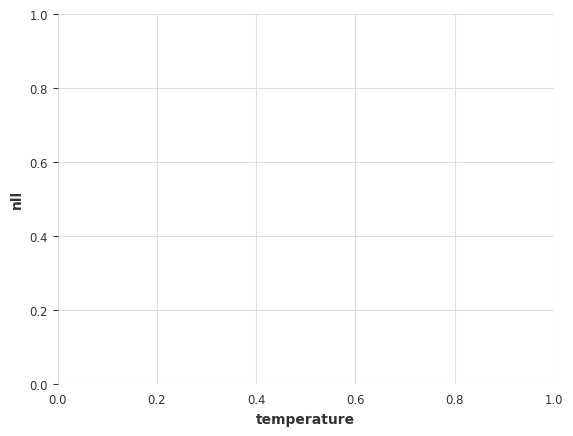

In [25]:
plt.xlabel("temperature")
plt.ylabel("nll")
# plt.ylim(1.15, 1.3)
plt.plot(temp_list[1:-1], nll_list[1:-1], marker = 'o')

---